# Analyze distributions

In [4]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import random
import time

# File download
from tqdm.notebook import tqdm, trange

# AWS S3 Storage
import boto3

# Custom modules
from Tools import S3

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Connect to AWS S3 storage
s3 = S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


## Download Data

In [6]:
# Read transformed files and inspect
# * Common colum nnames

date = "2022_03_24"

# Get list of avilable files -> do not know yet, if all uploads were successful
file_list = s3.listFiles(AWS_BUCKET, "data/distribution_trans/" + date)

# Extract ISIN from filename
df_file = pd.DataFrame(file_list, columns = ['file'])
df_file['ISIN'] = df_file['file'].str.extract(r"([A-Z0-9]{12})", expand = False).fillna('no match')

df_dist = pd.DataFrame(columns = ['Security_ISIN'])

for i, record in tqdm(df_file[0:].iterrows(), total = df_file[0:].shape[0]):

    key = record['file']
    isin = record['ISIN']

    filename = './temp/' + isin + ".tsv"

    s3.downloadFile(AWS_BUCKET, key, filename)

    # Read tsv file
    df_temp = pd.read_csv(filename, sep = "\t")

    # Rename columns
    df_temp = df_temp.rename(columns={
        'ExTag': 'Dist_Date_Ex',
        'Fälligkeitsdatum': 'Dist_Date_Payment',
        'Stichtag': 'Dist_Date_Record',
        'ISIN': 'Security_ISIN',
        'Dist': 'Dist_Amount'
    })

    df_dist = df_dist.append(df_temp)

  0%|          | 0/196 [00:00<?, ?it/s]

In [7]:
# Adjust order of columns
df_dist = df_dist[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']]
df_dist.head()

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,DE0002635265,0.077934,15.Mär.2022,NaN,15.Mär.2022
1,DE0002635265,0.08127,15.Dez.2021,NaN,15.Dez.2021
2,DE0002635265,0.08536,15.Sep.2021,NaN,15.Sep.2021
3,DE0002635265,0.088313,15.Jun.2021,NaN,15.Jun.2021
4,DE0002635265,0.091689,15.Mär.2021,NaN,15.Mär.2021


## Transform

In [8]:
# Check order of dates and distance between dates
# Ex < Record < Payment

# Select all observations, where all 3 dates are available
df_dist_dates = df_dist.dropna(subset=['Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment'], how='any').copy()

# Transform all date columns to datetime
from datetime import datetime
import locale

# Datetime doesnot recognie "Mär"|"Mar" with german locale de_DE
locale.setlocale(locale.LC_ALL, 'en_US')

d = {'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}

df_dist_dates['Dist_Date_Ex'] = pd.to_datetime(df_dist_dates['Dist_Date_Ex'].replace(d, regex=True), format="%d.%b.%Y")
df_dist_dates['Dist_Date_Record'] = pd.to_datetime(df_dist_dates['Dist_Date_Record'].replace(d, regex=True), format="%d.%b.%Y")
df_dist_dates['Dist_Date_Payment'] = pd.to_datetime(df_dist_dates['Dist_Date_Payment'].replace(d, regex=True), format="%d.%b.%Y")

# Calculate number of days between dates
df_dist_dates['D_Ex_Record'] = (df_dist_dates.Dist_Date_Record - df_dist_dates.Dist_Date_Ex).dt.days
df_dist_dates['D_Record_Payment'] = (df_dist_dates.Dist_Date_Payment - df_dist_dates.Dist_Date_Record).dt.days

## Analyze

### Summary

In [9]:
# Inspect distribution
df_dist_dates[['D_Ex_Record', 'D_Record_Payment']].describe()

,D_Ex_Record,D_Record_Payment
count,4159.000000,4159.000000
mean,1.216158,17.721087
std,6.247514,46.961690
min,-320.000000,-2896.000000
25%,1.000000,12.000000
50%,1.000000,19.000000
75%,2.000000,26.000000
max,30.000000,338.000000


### Distribution

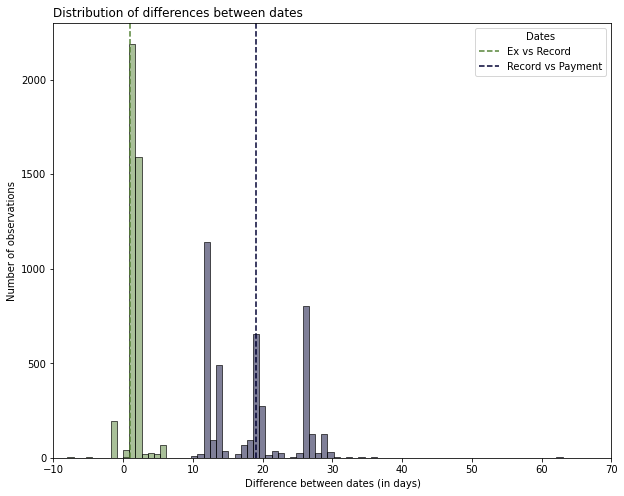

In [10]:
# Histogram of date differences
df_plot = df_dist_dates[['Security_ISIN', 'D_Ex_Record', 'D_Record_Payment']]

# Remove extreme outliers
df_plot = df_plot.loc[df_plot.D_Ex_Record > -10]
df_plot = df_plot.loc[df_plot.D_Record_Payment > -10]

# Calculate median values for vertical lines
med_D_Ex_Record = df_plot.D_Ex_Record.median()
med_D_Record_Payment = df_plot.D_Record_Payment.median()

# Reshape to tidy format
df_plot = pd.melt(df_plot, id_vars = ['Security_ISIN'], value_vars=['D_Ex_Record', 'D_Record_Payment'])

# Calcualte the range
# x_min, x_max = (df_plot.value.min(), df_plot.value.max())
x_min = -10
x_max = 70

# Define the colors
palette = {"D_Ex_Record": "#548235", "D_Record_Payment": "#000032"}

# Aggregate - for barplot
# df_plot = df_plot.groupby(['variable', 'value']).agg('count').rename(columns={'Security_ISIN':'n_'})

# df_plot = df_plot.reset_index()

# Draw the graph
fig = plt.figure(figsize=(10, 8))

sns.histplot(df_plot, x = 'value', hue = 'variable', bins = x_max - x_min, palette=palette)

plt.xlim([x_min, x_max])

plt.axvline(x = med_D_Ex_Record, color = palette['D_Ex_Record'], ls="--")
plt.axvline(x = med_D_Record_Payment, color = palette['D_Record_Payment'], ls="--")

# Labeling and titles
plt.title("Distribution of differences between dates", loc='left')

plt.xlabel('Difference between dates (in days)')
plt.ylabel('Number of observations')

plt.legend(title='Dates', loc='upper right', labels=['Ex vs Record', 'Record vs Payment'])

plt.show()

fig.savefig('graphics/B011_Distribution_of_date_differences.png')

# Payment within 1 month after ex/record date -> use that as conservative estimate for DQ-problems? Check for trends within ETF

## Data Quality

Algorithm to handle data errors, i.e. wrongly supplied dates

We will make some assumptions:
* Dates are wrong, when the order of dates is wrong
* Dates are wrong, when their difference lies outside the typically observed ranges, i.e. 25%/75% quantiles.

In a first step, dates are cleaned with values infered from the whole sample.

In a second step, there will be a two-step process:
* First take observations for the current product
* If they mostly seem erroneous, then take the whole sample values

In [11]:
# Apply to whole dataframe

# Add observation ID
df_dist_dates['OBS_ID'] = np.arange(len(df_dist_dates))

df_grouped = df_dist_dates.groupby(df_dist_dates['Security_ISIN'])

df_adj = pd.DataFrame()

for g in df_grouped.groups.keys():

    df_temp = df_grouped.get_group(g).copy()

    # Fix the order within date over time - start from earliest date on record
    for idx in reversed(df_temp.index):

        # Do not compare first observation
        if idx != 0:
            
            # Fix Ex Dates
            if df_temp.loc[idx, 'Dist_Date_Ex'] > df_temp.loc[idx - 1, 'Dist_Date_Ex']:

                # Fix date -> ex + 1
                new_date = df_temp.loc[idx - 1, 'Dist_Date_Record']  - pd.Timedelta(days=1)
                df_temp.loc[idx - 1, 'Dist_Date_Ex'] = new_date

                print(idx, df_temp.loc[idx, 'Dist_Date_Ex'], df_temp.loc[idx - 1, 'Dist_Date_Ex'])

            # Fix Record Dates
            # negative
            if df_temp.loc[idx, 'Dist_Date_Record'] > df_temp.loc[idx - 1, 'Dist_Date_Record']:

                # Fix date -> ex + 1
                new_date = df_temp.loc[idx - 1, 'Dist_Date_Ex']  + pd.Timedelta(days=1)
                df_temp.loc[idx - 1, 'Dist_Date_Record'] = new_date

                print(idx, df_temp.loc[idx, 'Dist_Date_Record'], df_temp.loc[idx - 1, 'Dist_Date_Record'])

            # Fix Payment dates
            if df_temp.loc[idx, 'Dist_Date_Payment'] > df_temp.loc[idx - 1, 'Dist_Date_Payment']:

                # Fix date -> Record + median date difference to payment date within current group
                new_date = df_temp.loc[idx - 1, 'Dist_Date_Record']  + pd.Timedelta(days=df_temp.D_Record_Payment.median())
                df_temp.loc[idx - 1, 'Dist_Date_Payment'] = new_date

                print(idx, df_temp.loc[idx, 'Dist_Date_Payment'], df_temp.loc[idx - 1, 'Dist_Date_Payment'])

    # Now, fix the order of dates: ex < record < payment
    for idx in df_temp.index:

        if df_temp.loc[idx, "Dist_Date_Record"] < df_temp.loc[idx, 'Dist_Date_Ex']:
            df_temp.loc[idx, 'Dist_Date_Record'] = df_temp.loc[idx, 'Dist_Date_Ex'] + pd.Timedelta(days=1)

        if df_temp.loc[idx, "Dist_Date_Payment"] < df_temp.loc[idx, 'Dist_Date_Record']:
            df_temp.loc[idx, 'Dist_Date_Payment'] = df_temp.loc[idx, 'Dist_Date_Record'] + pd.Timedelta(days=20)
    

    df_adj = df_adj.append(df_temp)



87 2000-04-09 00:00:00 2000-11-28 00:00:00
85 2001-02-03 00:00:00 2001-05-31 00:00:00
58 2007-11-28 00:00:00 2008-02-21 00:00:00
77 2002-12-13 00:00:00 2003-03-19 00:00:00
59 2007-11-30 00:00:00 2007-11-29 00:00:00
56 2008-03-26 00:00:00 2008-06-18 00:00:00
6 2020-10-30 00:00:00 2021-01-31 00:00:00


In [12]:
# Calculate new data differenecs and describe

# Calculate number of days between dates
df_adj['D_Ex_Record'] = (df_adj.Dist_Date_Record - df_adj.Dist_Date_Ex).dt.days
df_adj['D_Record_Payment'] = (df_adj.Dist_Date_Payment - df_adj.Dist_Date_Record).dt.days

df_adj.describe()

,D_Ex_Record,D_Record_Payment,OBS_ID
count,4159.000000,4159.000000,4159.000000
mean,1.510219,18.396249,2079.000000
std,1.025799,6.023263,1200.744214
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1039.500000
50%,1.000000,19.000000,2079.000000
75%,2.000000,26.000000,3118.500000
max,30.000000,63.000000,4158.000000


In [13]:
# Inspect date changes and the accuracy of the changes
# Display new describe()


df_check = df_dist_dates[['OBS_ID', 'Security_ISIN', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']].join(
    df_adj[['OBS_ID', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']]
    .rename(columns={'Dist_Date_Ex':'Dist_Date_Ex_Adj', 'Dist_Date_Record':'Dist_Date_Record_Adj', 'Dist_Date_Payment':'Dist_Date_Payment_Adj'})
    .set_index(['OBS_ID']),
    on =  ['OBS_ID']
)

# Print number of adjusted rows
print("Date Ex: {}".format(df_check.loc[df_check.Dist_Date_Ex != df_check.Dist_Date_Ex_Adj].shape[0]))
print("Date Record: {}".format(df_check.loc[df_check.Dist_Date_Record != df_check.Dist_Date_Record_Adj].shape[0]))
print("Date Payment: {}".format(df_check.loc[df_check.Dist_Date_Payment != df_check.Dist_Date_Payment_Adj].shape[0]))

# Inspect adjustment to date of payment
df_check.loc[df_check.Dist_Date_Payment != df_check.Dist_Date_Payment_Adj]


Date Ex: 0
Date Record: 204
Date Payment: 5


,OBS_ID,Security_ISIN,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment,Dist_Date_Ex_Adj,Dist_Date_Record_Adj,Dist_Date_Payment_Adj
57,145,IE0008470928,2008-01-30,2008-02-01,2007-02-27,2008-01-30,2008-02-01,2008-02-21
76,324,IE0031442068,2003-02-26,2003-02-28,2002-03-17,2003-02-26,2003-02-28,2003-03-19
59,463,IE0032895942,2007-10-31,2007-11-30,2007-11-28,2007-10-31,2007-11-30,2007-12-20
55,1160,IE00B0M62Y33,2008-05-28,2008-05-30,2000-06-25,2008-05-28,2008-05-30,2008-06-18
5,3783,IE00BDR08N26,2020-11-30,2020-11-30,2020-01-29,2020-11-30,2020-11-30,2021-01-31


In [17]:
# Upload as clean data

grouped = df_adj[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']].groupby(['Security_ISIN'])

# store as tsv
for g in grouped.groups.keys():

    temp = grouped.get_group(g)

    s3.uploadFile(
        df = temp, 
        name = g,
        dir = 'data/distribution_clean/' + date + "/",
        bucket = AWS_BUCKET
    )    
